In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [36]:
from sklearn.datasets import load_iris

iris = load_iris()
X = iris['data']
y = iris['target']

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1./3, random_state=1)

In [38]:
X_train_norm = (X_train - np.mean(X_train)) / np.stack(X_train)

In [39]:
import torch
X_train_norm = torch.from_numpy(X_train_norm).float()
y_train = torch.from_numpy(y_train)

In [40]:
y_train

tensor([0, 0, 2, 2, 2, 2, 2, 1, 2, 1, 0, 2, 2, 0, 0, 2, 0, 2, 2, 1, 1, 2, 2, 0,
        1, 1, 2, 1, 2, 1, 0, 0, 0, 2, 0, 1, 2, 2, 0, 0, 1, 0, 2, 1, 2, 2, 1, 2,
        2, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 2, 2, 2, 0, 0, 1, 0, 2, 0, 2, 2, 0, 2,
        0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 2, 0, 0, 2, 1, 2, 1, 2,
        2, 1, 2, 0])

In [41]:
from torch.utils.data import TensorDataset
train_ds = TensorDataset(X_train_norm, y_train)
train_ds

In [42]:
from torch.utils.data import DataLoader

torch.manual_seed(1)
batch_size = 2
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
train_dl

In [43]:
# 모델 만들기 => 입력, 은닉, 출력
import torch.nn as nn
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = nn.Softmax(dim=1)(x)
        return x

In [44]:
input_size = X_train_norm.shape[1]
hidden_size = 16
output_size = 3

model = Model(input_size=input_size, hidden_size=hidden_size, output_size=output_size)

lr = 0.001
loss_fn = nn.CrossEntropyLoss()
opti = torch.optim.Adam(model.parameters(), lr=lr)

In [45]:
num_epochs = 100
loss_hist = [0] * num_epochs
accuracy_hist = [0] * num_epochs

for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch.long())
        loss.backward()
        opti.step()
        opti.zero_grad()

        loss_hist[epoch] += loss.item() * y_batch.size(0)
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist[epoch] += is_correct.sum()

In [46]:
loss_hist[-5:-1], accuracy_hist[-5:-1]

([63.602535009384155, 63.46684491634369, 63.45495557785034, 63.34378516674042],
 [tensor(96.), tensor(96.), tensor(95.), tensor(96.)])

([<matplotlib.lines.Line2D at 0x1df17fc7c50>],
 [<matplotlib.lines.Line2D at 0x1df17f82570>])

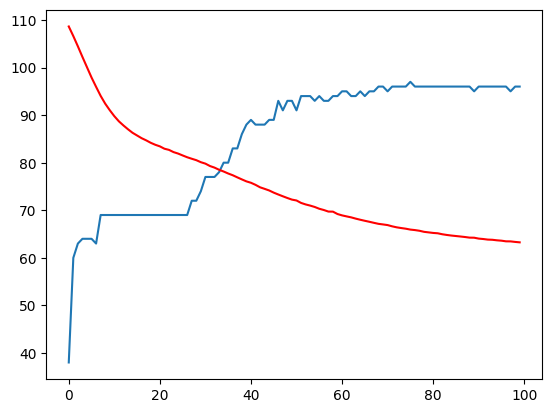

In [47]:
plt.plot(accuracy_hist), plt.plot(loss_hist, c='r')

In [48]:
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)
X_test_norm = torch.from_numpy(X_test_norm).float()
y_test = torch.from_numpy(y_test)
pred_test = model(X_test_norm)
correct = (torch.argmax(pred_test, dim=1) == y_test).float()
accuracy = correct.mean()
print(f'테스트 정확도: {accuracy: .4f}')

테스트 정확도:  0.5200
